In [1]:
from power_planner.utils import get_donut_vals, get_half_donut, get_distance_surface, bresenham_line, rescale, get_lg_donut, angle, normalize
from power_planner.plotting import plot_path, plot_path_costs
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time

In [2]:
from power_planner import graphs

In [3]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_5.dat"
with open(instance_path, "rb") as infile:
    data = pickle.load(infile)
(instance, instance_corr, start_inds, dest_inds) = data.data

In [4]:
min_dist = 3
max_dist = 5

In [9]:
class TwoPowerBF():
    
    def __init__(self,
        instance,
        instance_corr,
        graphtool=1,
        directed=True,
        verbose=1,
        n_iters=50,
        fill_val=np.inf
    ):
        self.graph_ab = graphs.PowerBF(instance, instance_corr, graphtool=1, verbose=1)
        self.graph_ba = graphs.PowerBF(instance, instance_corr, graphtool=1, verbose=1)

    def set_edge_costs(self, layer_classes, class_weights, angle_weight=0.5):
        self.graph_ab.set_edge_costs(layer_classes, class_weights, angle_weight=angle_weight)
        self.graph_ba.set_edge_costs(layer_classes, class_weights, angle_weight=angle_weight)

    def set_shift(self, min_dist, max_dist, vec, max_angle, max_angle_lg):
        self.graph_ab.set_shift(min_dist, max_dist, vec, max_angle, max_angle_lg)
        self.graph_ba.set_shift(min_dist, max_dist, np.asarray(vec)*(-1), max_angle, max_angle_lg)
        
    def add_nodes(self):
        self.graph_ab.add_nodes()
        self.graph_ba.add_nodes()

    def set_corridor(self, factor, corridor, start_inds, dest_inds):
        self.graph_ab.set_corridor(factor, corridor, start_inds, dest_inds)
        self.graph_ba.set_corridor(factor, corridor, dest_inds, start_inds)
        
    def add_edges(self):
        self.graph_ab.add_edges()
        self.graph_ba.add_edges()

    def get_shortest_path(self, start_inds, dest_inds):
        self.path_ab, _, _ = self.graph_ab.get_shortest_path(start_inds, dest_inds)
        self.path_ba, _, _ = self.graph_ba.get_shortest_path(dest_inds, start_inds)
        assert np.all(np.flip(np.asarray(self.path_ba), axis=0)==self.path_ab)

    def best_in_window(self, w_xmin, w_xmax, w_ymin, w_ymax, start_ind, dest_inds, margin=0.05):
        """
        margin: percent that it's allowed to be higher than average
        """
        opt = np.min(self.graph_ab.dists[:, dest_inds[0], dest_inds[1]])
                
        possible_cs = []
        for x in range(w_xmin, w_xmax+1, 1):
            for y in range(w_ymin, w_ymax+1, 1):
                # todo here: take into account angle directly
                added_costs = np.min(self.graph_ab.dists[:, x, y]) +  np.min(self.graph_ba.dists[:, x, y]) - self.graph_ab.instance[x,y]
                if added_costs < opt + margin * opt:
                    possible_cs.append(np.array([x,y]))
        for c in possible_cs:
            path_ac = self.graph_ab.get_shortest_path(start_inds, c, ret_only_path=True)
            path_cb = self.graph_ba.get_shortest_path(dest_inds, c, ret_only_path=True)
            plt.plot(path_ac[:,0], path_ac[:,1])
            plt.plot(path_cb[:,0], path_cb[:,1])
            plt.show()

In [ ]:
graph = TwoPowerBF(
    instance, instance_corr, graphtool=1, verbose=1
)

graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=0.1
)
graph.set_shift(min_dist, max_dist, dest_inds-start_inds, 0.5*np.pi, 0.25*np.pi)

# add vertices
graph.add_nodes()

graph.set_corridor(1, None, start_inds, dest_inds)
print("1) set cost rest")

graph.add_edges()


In [11]:
# get actual best path
graph.get_shortest_path(start_inds, dest_inds)
print("3) shortest path")

3) shortest path


In [64]:
def get_sp(dists, dists_argmin, start_inds, dest_inds, shifts, min_shift):
    if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
        raise RuntimeWarning("empty path")
    curr_point = dest_inds
    my_path = [dest_inds]
    # min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
    while np.any(curr_point - start_inds):
        new_point = curr_point - shifts[int(min_shift)]
        min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
        my_path.append(new_point)
        curr_point = new_point
    return np.asarray(my_path)

def best_in_window(two_power_obj, w_xmin, w_xmax, w_ymin, w_ymax, start_ind, dest_inds, margin=0.05):
    """
    margin: percent that it's allowed to be higher than average
    """
    opt = np.min(two_power_obj.graph_ab.dists[:, dest_inds[0], dest_inds[1]])

    ang_weight = two_power_obj.graph_ba.angle_weight
    ang_norm_factor = two_power_obj.graph_ba.angle_norm_factor
            
    possible_cs = []
    c_path_cost = []
    possible_shifts = []
            
    for x in range(w_xmin, w_xmax+1, 1):
        for y in range(w_ymin, w_ymax+1, 1):
            # todo here: take into account angle directly
            cell_val = two_power_obj.graph_ab.instance[x,y]
            if cell_val < np.inf:
                min_costs = np.inf
                min_shifts = [0,0]
                for s1 in range(len(two_power_obj.graph_ab.shifts)):
                    for s2 in range(len(two_power_obj.graph_ab.shifts)):
                        val_ab = two_power_obj.graph_ab.dists[s1, x, y]
                        shift_ab = two_power_obj.graph_ab.shifts[s1]
                        val_ba = two_power_obj.graph_ba.dists[s2, x, y]
                        shift_ba = two_power_obj.graph_ba.shifts[s2]
                        ang = angle(np.asarray(shift_ab), np.asarray(shift_ba)*(-1))
                        added_costs = val_ab + val_ba - cell_val + ang_weight * ang / ang_norm_factor
                        if added_costs < min_costs:
                            min_costs = added_costs
                            min_shifts = [s1, s2]
                possible_shifts.append(min_shifts)
                added_costs = min_costs # np.min(two_power_obj.graph_ab.dists[:, x, y]) +  np.min(two_power_obj.graph_ba.dists[:, x, y]) - two_power_obj.graph_ab.instance[x,y]
            else:
                possible_shifts.append([0,0])
                added_costs = np.inf
            possible_cs.append(np.array([x,y]))
            c_path_cost.append(min_costs)
            
    # get best one
    best_c = np.argmin(c_path_cost)
    print(best_c)
    c = possible_cs[best_c]
    s1, s2 = possible_shifts[best_c]
    # stick together the path
    path_ac = get_sp(two_power_obj.graph_ab.dists, two_power_obj.graph_ab.dists_argmin, start_inds, c, two_power_obj.graph_ab.shifts, s1)
    path_cb = get_sp(two_power_obj.graph_ba.dists, two_power_obj.graph_ba.dists_argmin, dest_inds, c, two_power_obj.graph_ba.shifts, s2)
    # path_ac = two_power_obj.graph_ab.get_shortest_path(start_inds, c, ret_only_path=True)
    # path_cb = two_power_obj.graph_ba.get_shortest_path(dest_inds, c, ret_only_path=True)
    # return concatenated path and new costs
    print(opt, c_path_cost[best_c], c)
    together = np.concatenate((np.flip(np.array(path_ac), axis=0), np.array(path_cb)), axis=0)
    plt.plot(path_ac[:,0], path_ac[:,1])
    plt.plot(path_cb[:,0], path_cb[:,1])
    plt.show()
    return together
    

11
8.378379633583315 8.378379633583315 [ 71 190]


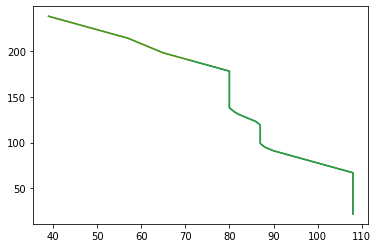

In [65]:
new_path = best_in_window(graph, 70,75, 185, 190, start_inds, dest_inds, margin = 0.2)

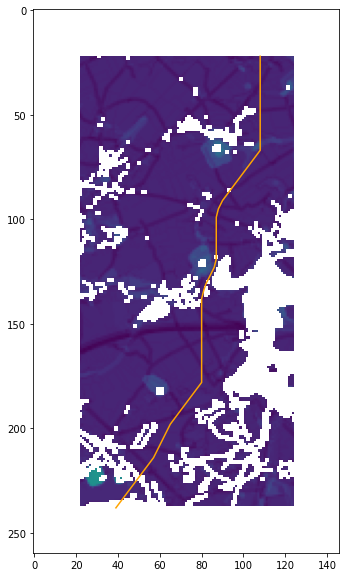

In [63]:
path = np.array(graph.path_ab)
plt.figure(figsize=(20,10))
plt.imshow(np.swapaxes(graph.graph_ab.instance,1,0))
plt.plot(path[:,0], path[:,1],color="yellow")
plt.plot(new_path[:,0], new_path[:,1],color="orange")
plt.show()

In [48]:
class BFangleKSP():
    
    def __init__(self, bf_graph):
        self.graph = bf_graph
        self.dists_ab = bf_graph.dists.copy()
        self.dists_argmin_ab = bf_graph.dists_argmin.copy()
        self.path_ab = bf_graph.best_path
        
    def add_ba(self):
        graph.shifts = np.array(self.graph.shifts) * (-1)
        # set dists to zero
        self.graph.add_nodes()
        # set dists of dest_inds
        self.graph.set_corridor(1, None, dest_inds, start_inds)
        # compute dists array
        self.graph.add_edges()
        # save new results
        self.dists_ba = self.graph.dists
        self.dists_argmin_ba = self.graph.dists_argmin
        self.path_ba, _, _ = self.graph.get_shortest_path(dest_inds, start_inds)
        assert np.all(np.flip(np.asarray(self.path_ba), axis=0)==self.path_ab)

    

    # best_in_window(45, 48, 60, 63, dists_ab, dists_ba, dest_inds, test_example)
        
        
    def on_path(self, point, best_path):
        point = np.array(point)
        return any([not np.any(point-p) for p in best_path])
        # test:
        # print(on_path(best_path[20], best_path), on_path(best_path[20]+1, best_path))
        
           
    @staticmethod
    def get_sp(dists, dists_argmin, start_inds, dest_inds, shifts):
        if not np.any(dists[:, dest_inds[0], dest_inds[1]] < np.inf):
            raise RuntimeWarning("empty path")
        curr_point = dest_inds
        my_path = [dest_inds]
        min_shift = np.argmin(dists[:, dest_inds[0], dest_inds[1]])
        while np.any(curr_point - start_inds):
            new_point = curr_point - shifts[int(min_shift)]
            min_shift = dists_argmin[int(min_shift), curr_point[0], curr_point[1]]
            my_path.append(new_point)
            curr_point = new_point
        return np.asarray(my_path)

In [49]:
bf_ang = BFangleKSP(graph)

In [50]:
bf_ang.add_ba()

memory taken (dists shape): 1062880
weights 0.1 1


In [53]:
bf_ang.best_in_window(80,90, 140, 150, start_inds, dest_inds)

NameError: name 'shifts_ab' is not defined

## with graph-tool

In [67]:
from graph_tool.all import *

In [117]:
graph = Graph(directed=True)
graph.add_vertex(40)
for i in range(20): # np.random.randint(0,40,50):
    second = np.random.randint(0,40,10)
    for s in second:
        graph.add_edge(i,s)

In [98]:
[v for v in graph.vertex(5).out_edges()]

[<Edge object with source '5' and target '31' at 0x150edf630>,
 <Edge object with source '5' and target '34' at 0x150edf6b0>,
 <Edge object with source '5' and target '24' at 0x150edf730>,
 <Edge object with source '5' and target '24' at 0x150edf7b0>,
 <Edge object with source '5' and target '35' at 0x150edf830>,
 <Edge object with source '5' and target '29' at 0x150edf8b0>,
 <Edge object with source '5' and target '38' at 0x150edf930>,
 <Edge object with source '5' and target '12' at 0x150edf9b0>,
 <Edge object with source '5' and target '38' at 0x150edfa30>,
 <Edge object with source '5' and target '13' at 0x150edfb30>]

In [130]:
source = 5
target=3

In [133]:
vertices, _ = shortest_path(
                graph,
                source,
                target
            )

In [134]:
vertices

[<Vertex object with index '5' at 0x1561ea210>,
 <Vertex object with index '2' at 0x1561ea9f0>,
 3]

In [ ]:
3-18-5  5-2-3

In [139]:
dist_map_ab, pred_map_ab = shortest_distance(
                graph,
                source,
                pred_map=True
            )

In [141]:
dist_map_ab[target], pred_map_ab[target]

(2, 2)

In [142]:
graph.set_reversed(is_reversed=True)

In [143]:
dist_map_ba, pred_map_ba = shortest_distance(
        graph,
        target,
    pred_map = True
    )

In [144]:
dist_map_ba[source], pred_map_ba[source]

(2, 2)

In [147]:
def get_sp_from_preds(pred_map, curr_vertex, start_vertex):
    path = [curr_vertex]
    while curr_vertex != start_vertex:
        curr_vertex = pred_map[curr_vertex]
        path.append(curr_vertex)
    return path

In [148]:
get_sp_from_preds(pred_map_ba, source, target)

[5, 2, 3]

In [222]:
shifts = get_half_donut(3,5,[1,0])
np.asarray(shifts)

array([[ 0, -5],
       [ 0, -4],
       [ 0, -3],
       [ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 1, -4],
       [ 1, -3],
       [ 1,  3],
       [ 1,  4],
       [ 2, -4],
       [ 2, -3],
       [ 2,  3],
       [ 2,  4],
       [ 3, -4],
       [ 3, -3],
       [ 3, -2],
       [ 3, -1],
       [ 3,  0],
       [ 3,  1],
       [ 3,  2],
       [ 3,  3],
       [ 3,  4],
       [ 4, -3],
       [ 4, -2],
       [ 4, -1],
       [ 4,  0],
       [ 4,  1],
       [ 4,  2],
       [ 4,  3],
       [ 5,  0]])

In [149]:
get_sp_from_preds(pred_map_ab, target, source)

[3, 2, 5]

In [166]:
a = [[1,2],[3,4]]
a.reverse()

In [167]:
a

[[3, 4], [1, 2]]

In [ ]:
def best_in_window(
        graph,
        w_xmin,
        w_xmax,
        w_ymin,
        w_ymax,
        source,
        dest,
        margin=0.05
    ):
    for x in range(w_xmin, w_xmax + 1, 1):
        for y in range(w_ymin, w_ymax + 1, 1):
            v = pos2node[x,y]
            # get dists_map_ab[v]
            # get_sp_from_preds(pred_map_ba, source, target)

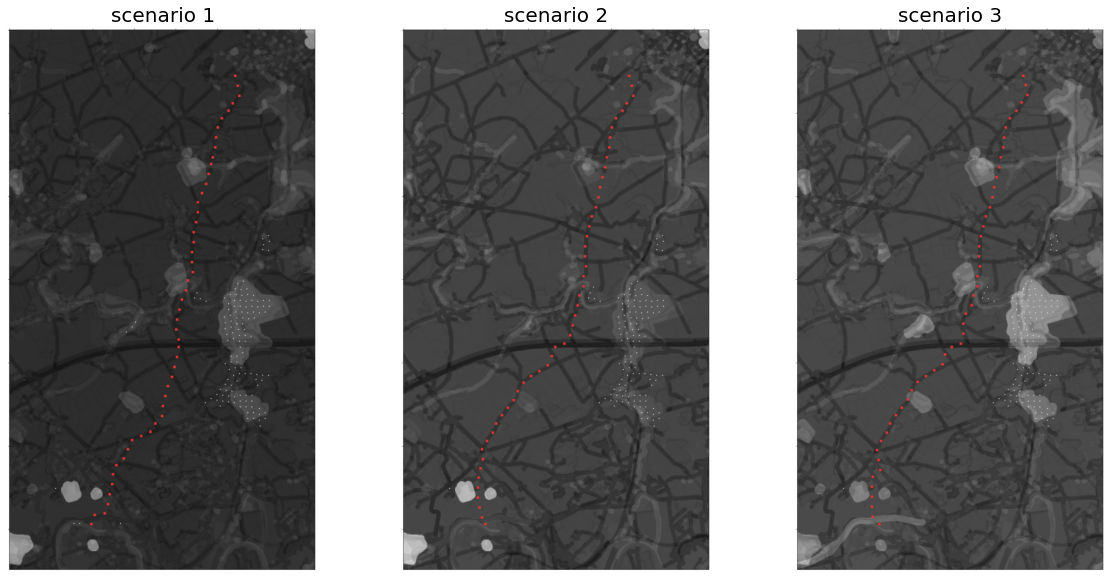

In [164]:
path = "/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/scenarios/path_scenario"

plt.figure(figsize=(20,10))
for i, img_name in enumerate(["1.png", "2.png", "3.png"]):
    img = plt.imread(path+img_name)
    plt.subplot(1,3,i+1)
    plt.imshow(img[40:, 25:])
    plt.axis("off")
    plt.title("scenario "+img_name[0], fontsize=20)
plt.savefig(path+".pdf")
plt.show()

In [191]:
import json
with open("/Users/ninawiedemann/Desktop/thesis.nosync/power_planner/outputs/path_kshortest_ksp.json", "r") as outfile:
    ksp = json.load(outfile)
    

In [192]:
ksp[0]

[[[108, 22],
  [111, 26],
  [111, 31],
  [108, 35],
  [105, 39],
  [102, 43],
  [99, 47],
  [99, 52],
  [99, 57],
  [99, 62],
  [99, 67],
  [99, 72],
  [99, 77],
  [96, 81],
  [93, 85],
  [90, 89],
  [88, 93],
  [88, 98],
  [88, 103],
  [87, 107],
  [87, 112],
  [88, 116],
  [85, 120],
  [85, 125],
  [83, 129],
  [83, 134],
  [80, 138],
  [80, 143],
  [80, 148],
  [77, 152],
  [74, 156],
  [71, 160],
  [67, 163],
  [63, 166],
  [59, 169],
  [55, 172],
  [51, 175],
  [51, 180],
  [48, 184],
  [45, 188],
  [41, 191],
  [41, 196],
  [41, 201],
  [41, 206],
  [44, 210],
  [44, 215],
  [44, 220],
  [44, 225],
  [42, 229],
  [42, 234],
  [39, 238]],
 [[0.0, 0.0, 0.39520000000000005, 0.48275862068965514],
  [0.0, 0.0, 0.32800000000000007, 0.48275862068965514],
  [0.0, 0.0, 0.488, 0.31724137931034485],
  [0.0, 0.0, 0.488, 0.31034482758620696],
  [0.0, 0.0, 0.3936, 0.31724137931034485],
  [0.0, 0.0, 0.344, 0.31034482758620696],
  [0.0, 0.0, 0.52, 0.31034482758620696],
  [0.0, 0.0, 0.57600000000

In [193]:
costs = [k[2] for k in ksp]
print(costs)

[7.917159424382088, 7.997913649467351, 8.022495384973222, 8.01853630956587, 8.027378143593914, 8.033308874931539, 8.029298871142226, 8.007011641130859, 8.020195422866363, 7.9823262299902735, 7.91157276276784, 7.968703190960338, 7.953870299713653]


In [194]:
paths = [k[0] for k in ksp]

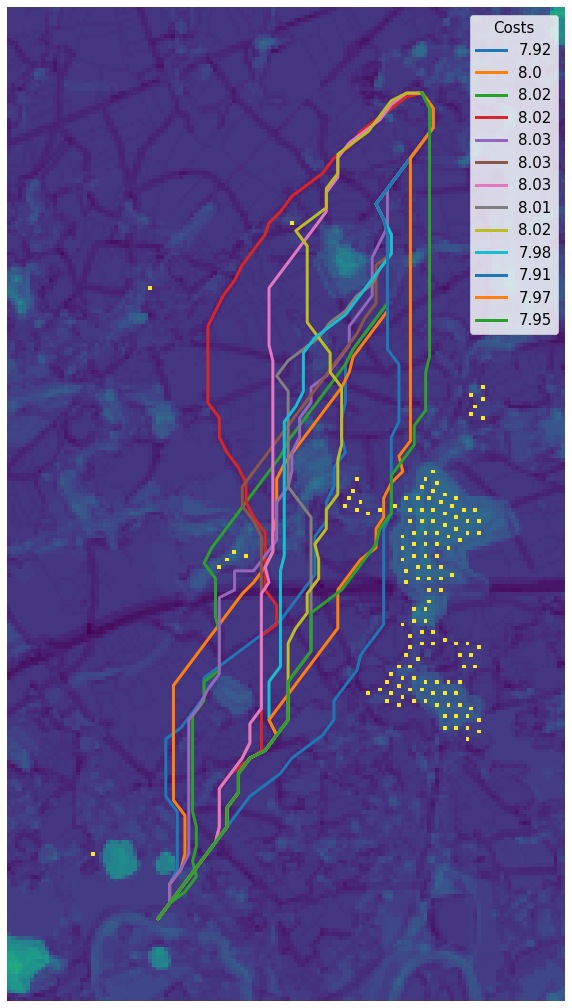

In [216]:
plt.figure(figsize=(10,20))
plt.imshow(np.swapaxes(np.mean(instance, axis=0), 1, 0))
# plt.imshow(np.swapaxes(instance[1:], 2,0), vmin=0, vmax=0.2)
for i, path in enumerate(paths):
    path = np.asarray(path)
    plt.plot(path[:,0], path[:,1], label=str(round(costs[i], 2)), linewidth=3)

leg = plt.legend(fontsize=15)
leg.set_title('Costs',prop={'size':15})
# plt.legend(title="costs", fontsize=15, )
plt.axis("off")
plt.savefig("k_shortest.pdf")
plt.show()

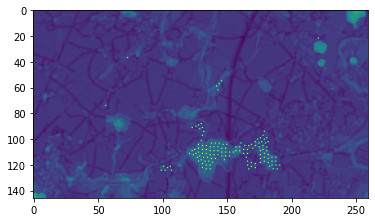